# Zilch Interview - Feature EDA

This notebook will explore each of the features in the training set. The goals are:

1. Understand the underlying distribution of each feature and its relationship to the outcome variable `credit_score_target`.
2. Check each feature for errors and define the preprocessing steps required for each.
3. Begin to define some of the code necessary to build a `scikit-learn` pipeline - which is how I will transfer to the train and validation sets.

Not in scope for this notebook:

1. Model training or selection.
2. Outputting "clean" data for training.

My assumption is that the train, test and validation sets can be considered as "raw data". Therefore, any machine learning pipeline I build should handle that data in the form closest to how we receive it (presumably from some API). Thus, everything I do here will be working towards building a single `scikit-learn` pipeline object that can handle each of the datasets with no other interventions.

Likewise, I expect that a lot of the features will have many null values. In a production environment, this is the reality and so I don't want to remove any data just because it is null. There may be exceptions where the data is not MAR (missing at random). Because of this, my pipeline should be able to handle nulls - already I am thinking this is where gradient-boosting type models will be helpful.

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Live reload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [101]:
# Import training dataset
train_df = pd.read_csv("../data/external/train.csv")
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 30 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   customer_id                 100000 non-null  object 
 1   month                       100000 non-null  object 
 2   name                        100000 non-null  object 
 3   age                         100000 non-null  object 
 4   address                     100000 non-null  object 
 5   email                       100000 non-null  object 
 6   national_insurance_number   100000 non-null  object 
 7   occupation                  100000 non-null  object 
 8   annual_income               100000 non-null  float64
 9   monthly_inhand_salary       84998 non-null   float64
 10  num_bank_accounts           100000 non-null  int64  
 11  num_credit_card             100000 non-null  int64  
 12  interest_rate               100000 non-null  int64  
 13  num_of_loan    

In [102]:
train_df.head()

,customer_id,month,name,age,address,email,national_insurance_number,occupation,annual_income,monthly_inhand_salary,...,credit_utilization_ratio,credit_utilization_ratio_2,credit_utilization_ratio_3,credit_history_age,payment_of_min_amount,total_emi_per_month,amount_invested_monthly,payment_behaviour,monthly_balance,credit_score_target
0,e2239bb1-a3ad-4d04-9d2c-77334dcf8cbb,January,Lisa Wright-Phillips,23,"380 Kimberley fall, Port Nathanburgh, West Dun...",lisa.wright-phillipsmd9o@gmail.com,ZG029369J,Scientist,19114.12,1824.843333,...,26.822620,26.822620,26.822620,22 Years and 1 Months,No,49.574949,80.415295,High_spent_Small_value_payments,312.494089,721.0
1,1c6c0050-2bb2-469e-961c-583ff43d43e8,February,Dr Rachel Horton,23,"721 Amanda ports, Brianmouth, West Dunbartonsh...",dr.horton86@outlook.com,SQ701806W,Scientist,19114.12,NaN,...,31.944960,31.944960,31.944960,NaN,No,49.574949,118.280222,Low_spent_Large_value_payments,284.629162,726.0
2,a210a4f2-01dc-405f-841a-50e4648ea899,March,Dr Billy Burgess,-500,"604 Taylor hills, Port Samuelfurt, Aberdeenshi...",dr.burgesspx@yahoo.com,PS226897E,Scientist,19114.12,NaN,...,28.609352,28.609352,28.609352,22 Years and 3 Months,No,49.574949,81.699521,Low_spent_Medium_value_payments,331.209863,716.0
3,5e6aca9f-cc80-46c6-b461-c7aa6f947fd3,April,Valerie Young,23,"1 Ryan vista, Spencerport, Lincolnshire, OX15 ...",valerie.young2a63@outlook.com,XQ464206S,Scientist,19114.12,NaN,...,31.377862,31.377862,31.377862,22 Years and 4 Months,No,49.574949,199.458074,Low_spent_Small_value_payments,223.451310,710.0
4,86dcfcae-ef86-47af-89c4-bb6e066b5fe0,May,Lydia Phillips,23,"5 Gardner highway, Stanleyborough, Dorset, G19...",lydia.phillipsjg@yahoo.com,KE225709Y,Scientist,19114.12,1824.843333,...,24.797347,24.797347,24.797347,22 Years and 5 Months,No,49.574949,41.420153,High_spent_Medium_value_payments,341.489231,738.0


In [103]:
# Drop unnecessary columns
DROP_COLS = [
    "customer_id",
    "month",
    "name",
    "address",
    "email",
    "national_insurance_number",
]

train_df_light = train_df.drop(columns=DROP_COLS)
print(f"Remaining columns: {train_df_light.columns.to_list()}")

Remaining columns: ['age', 'occupation', 'annual_income', 'monthly_inhand_salary', 'num_bank_accounts', 'num_credit_card', 'interest_rate', 'num_of_loan', 'type_of_loan', 'delay_from_due_date', 'num_of_delayed_payment', 'changed_credit_limit', 'num_credit_inquiries', 'outstanding_debt', 'credit_utilization_ratio', 'credit_utilization_ratio_2', 'credit_utilization_ratio_3', 'credit_history_age', 'payment_of_min_amount', 'total_emi_per_month', 'amount_invested_monthly', 'payment_behaviour', 'monthly_balance', 'credit_score_target']


## Feature EDA

I'll go through each of the remaining features and check for any errors and look at the distributions. It's also useful to plot vs. credit score here to get a better sense of the relationship.

In [104]:
# Create a DataFrame for the cleaned data
train_df_cleaned = pd.DataFrame()
train_df_cleaned["credit_score_target"] = train_df_light["credit_score_target"]

### Age

In [105]:
train_df_light["age"].describe()

count     100000
unique      1788
top           38
freq        2833
Name: age, dtype: object

First thing off the bat is that the column is not numerical, so there's probably some faulty text in there somewhere. Let's take a look.

In [106]:
# Print values where not numerical
train_df_light["age"].apply(lambda x: x if not x.isnumeric() else None).dropna()

2        -500
8         28_
54        34_
58        30_
71        24_
         ... 
99933     38_
99937    -500
99942     48_
99963    -500
99987     28_
Name: age, Length: 5825, dtype: object

There are trailing underscores for some data and some negative values which I assume should be null. I'll write a cleaning function and apply.

In [107]:
from sklearn.base import BaseEstimator, TransformerMixin

class StringStripper(BaseEstimator, TransformerMixin):
    def __init__(self, strip_char: str = "_"):
        """Initializes the transformer with the character to strip from the string.

        Args:
            strip_char (str, optional): Character to strip. Defaults to "_".
        """
        self.strip_char = strip_char

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        def parse_string(string: str) -> int:
            """Parses a string to extract an integer age value.

            string (str): The string containing the age value. It may contain underscores.

            int: The parsed integer age value. If the string cannot be directly converted to an integer,
                    it attempts to strip underscores and convert again.

            Raises:
                ValueError: If the string cannot be converted to an integer even after stripping underscores.
            """
            try:
                return int(string)
            except ValueError:
                return int(string.strip(self.strip_char))

        X = X.copy()
        X = X.apply(parse_string)
        return X

# Apply the transformer to the DataFrame
string_stripper = StringStripper()
train_df_cleaned["age"] =  string_stripper.fit_transform(train_df_light["age"])

In [108]:
train_df_cleaned["age"].describe()

count    100000.000000
mean        110.649700
std         686.244717
min        -500.000000
25%          24.000000
50%          33.000000
75%          42.000000
max        8698.000000
Name: age, dtype: float64

Notice that there are negative values for age, and also some incorrect large values. I'll turn these to null in order to stick with my principle of not dropping data and embracing nulls.

Rather than just hard-coding a cutoff, I'll write a more flexible transformer that nullifies values outside of an IQR * scale factor (used commonly for univariate anomaly detection).

In [109]:
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, factor=2.5):
        self.factor = factor

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for column in X.columns:
            q1 = X[column].quantile(0.25)
            q3 = X[column].quantile(0.75)
            iqr = q3 - q1

            lower_bound = q1 - self.factor * iqr
            upper_bound = q3 + self.factor * iqr

            X[column] = X[column].apply(lambda x: x if lower_bound <= x <= upper_bound else None)
        return X

# Example usage:
outlier_remover = OutlierRemover(factor=2.5)
train_df_cleaned = outlier_remover.fit_transform(train_df_cleaned)

In [110]:
train_df_cleaned["age"].describe()

count    97219.000000
mean        33.320009
std         10.769558
min         14.000000
25%         24.000000
50%         33.000000
75%         42.000000
max         56.000000
Name: age, dtype: float64

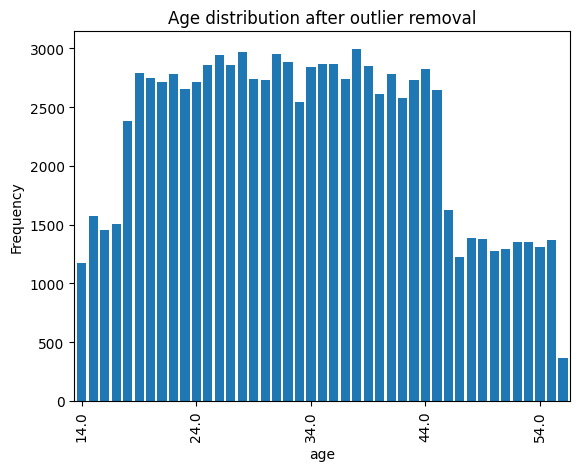

In [111]:
# Plot the age distribution after outlier removal
def plot_discrete_distribution(data: pd.Series, title: str, show_every: int = 10):
    ax = data.value_counts().sort_index().plot(kind="bar", width=0.8)
    ax.set_ylabel("Frequency")
    ax.set_xticks(ax.get_xticks()[::show_every])  # Show every 10th tick
    plt.title(title)
    plt.show()

plot_discrete_distribution(train_df_cleaned["age"].dropna(), "Age distribution after outlier removal")

I'm happy with those two transformers. Hopefully by building the second one it can be re-used for some of the other features. 

Finally let's take a look at the relationship between this variable and the outcome.

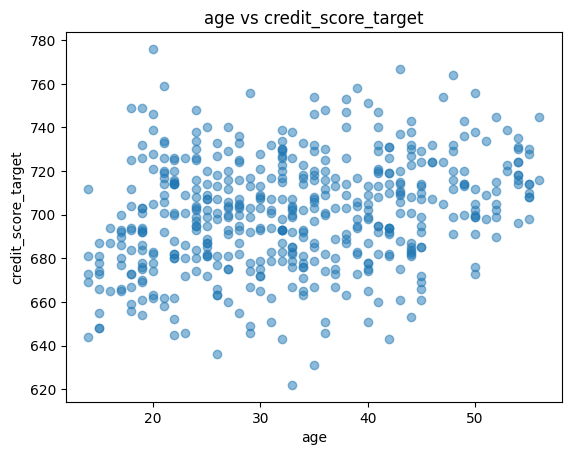

In [112]:
def plot_numerical_feature_vs_target(
    data: pd.DataFrame,
    feature: str,
    target: str = "credit_score_target",
    sample_size: int = None
):
    if sample_size:
        data = data.sample(sample_size)
    plt.scatter(data[feature], data[target], alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel(target)
    plt.title(f"{feature} vs {target}")
    plt.show()
    
plot_numerical_feature_vs_target(train_df_cleaned, "age", sample_size=500)

We see a small positive correlation between age and credit score, which is what I would expect.

### Occupation

In [113]:
train_df_light["occupation"].describe()

count      100000
unique         16
top       _______
freq         7062
Name: occupation, dtype: object

In [114]:
train_df_light["occupation"].value_counts(dropna=False)

occupation
_______          7062
Lawyer           6575
Architect        6355
Engineer         6350
Scientist        6299
Mechanic         6291
Accountant       6271
Developer        6235
Media_Manager    6232
Teacher          6215
Entrepreneur     6174
Doctor           6087
Journalist       6085
Manager          5973
Musician         5911
Writer           5885
Name: count, dtype: int64

In [115]:
# Replace the "_______" values with "Unknown" for clarity
from sklearn.impute import SimpleImputer

blank_line_remover = SimpleImputer(missing_values="_______", strategy="constant", fill_value="Unknown")
train_df_cleaned["occupation"] = blank_line_remover.fit_transform(train_df_light[["occupation"]]).flatten()
train_df_cleaned["occupation"].value_counts(dropna=False)

occupation
Unknown          7062
Lawyer           6575
Architect        6355
Engineer         6350
Scientist        6299
Mechanic         6291
Accountant       6271
Developer        6235
Media_Manager    6232
Teacher          6215
Entrepreneur     6174
Doctor           6087
Journalist       6085
Manager          5973
Musician         5911
Writer           5885
Name: count, dtype: int64

I'm happy with the quality of this in general. I'll include these in the model, would also be good to use these features to explore the model outputs later.

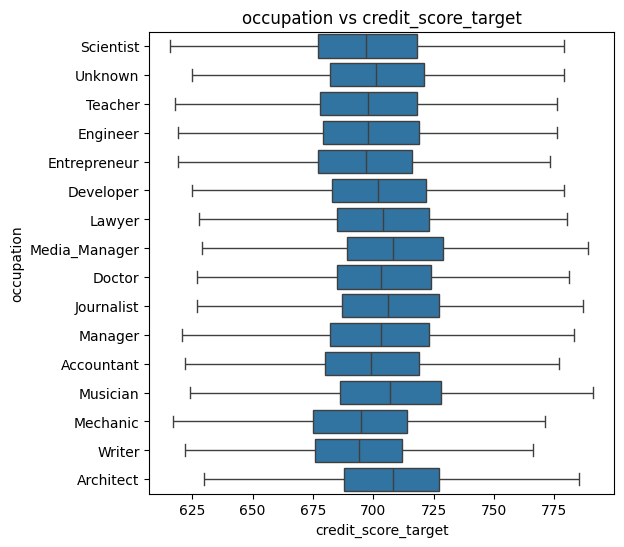

In [116]:
def plot_categorical_feature_vs_target(
    data: pd.DataFrame,
    feature: str,
    target: str = "credit_score_target",
    showfliers: bool = False
):
    # Plot boxplots for each category vs the target, horizontally
    plt.figure(figsize=(6, 6))
    sns.boxplot(x=target, y=feature, data=data, orient="h", showfliers=showfliers)
    plt.title(f"{feature} vs {target}")
    plt.show()

    
plot_categorical_feature_vs_target(train_df_cleaned, "occupation")

Nothing much to report on here, some professions are generally higher than others but there's no obvious patterns. We'll see if a gradient boosting style model picks up on anything. This does seem like a pretty standard feature to put into the model.

### Annual Income

In [117]:
train_df_light["annual_income"].describe()

count    1.000000e+05
mean     1.764157e+05
std      1.429618e+06
min      7.005930e+03
25%      1.945750e+04
50%      3.757861e+04
75%      7.279092e+04
max      2.419806e+07
Name: annual_income, dtype: float64

<Axes: ylabel='Frequency'>

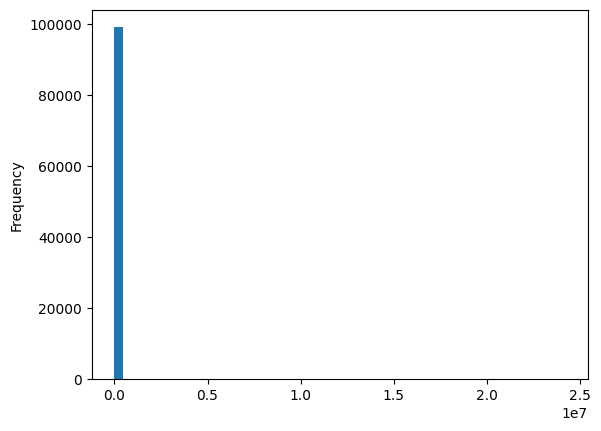

In [118]:
train_df_light["annual_income"].plot(kind="hist", bins=50)

Getting some heavily right-skewed data for this feature. May just be the reality, I'll check the highest earners to see what's going on.

In [119]:
train_df_light.sort_values("annual_income", ascending=False).head(1005)

,age,occupation,annual_income,monthly_inhand_salary,num_bank_accounts,num_credit_card,interest_rate,num_of_loan,type_of_loan,delay_from_due_date,...,credit_utilization_ratio,credit_utilization_ratio_2,credit_utilization_ratio_3,credit_history_age,payment_of_min_amount,total_emi_per_month,amount_invested_monthly,payment_behaviour,monthly_balance,credit_score_target
48302,31,Engineer,24198062.00,1135.525417,4,5,5,4.0,"Personal Loan, Auto Loan, Student Loan, and Cr...",15,...,34.790192,34.790192,34.790192,18 Years and 4 Months,No,46.388945,53.573863,Low_spent_Large_value_payments,283.589734,638.0
7814,17,Lawyer,24188807.00,1067.655833,8,6,23,9.0,"Student Loan, Home Equity Loan, Student Loan, ...",47,...,41.268945,41.268945,41.268945,10 Years and 1 Months,NM,87.323423,25.385696,High_spent_Small_value_payments,254.056464,617.0
59059,21,Mechanic,24177153.00,2373.828333,4,3,6,0.0,NaN,6,...,39.408584,39.408584,39.408584,21 Years and 2 Months,No,0.000000,136.175542,Low_spent_Medium_value_payments,381.207291,630.0
14588,38,Teacher,24160009.00,3852.982500,10,6,28,8.0,"Personal Loan, Mortgage Loan, Not Specified, P...",38,...,25.225734,25.225734,25.225734,12 Years and 11 Months,Yes,196.888046,159.593972,High_spent_Medium_value_payments,278.816232,611.0
27262,51,Lawyer,24105369.00,3165.787500,3,7,7,3.0,"Personal Loan, Personal Loan, and Home Equity ...",3,...,29.621716,29.621716,29.621716,31 Years and 4 Months,No,57.514937,237.622977,Low_spent_Medium_value_payments,301.440837,646.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15688,34,Mechanic,179987.28,14816.940000,5,5,8,4.0,"Mortgage Loan, Auto Loan, Personal Loan, and C...",14,...,25.437590,25.437590,25.437590,20 Years and 7 Months,No,417.843991,1706.877877,Low_spent_Small_value_payments,NaN,719.0
15692,35,Mechanic,179987.28,14816.940000,5,5,8,4.0,"Mortgage Loan, Auto Loan, Personal Loan, and C...",14,...,43.339655,43.339655,43.339655,20 Years and 11 Months,No,417.843991,563.169840,High_spent_Medium_value_payments,750.680169,729.0
15690,35_,Mechanic,179987.28,14816.940000,5,5,8,4.0,"Mortgage Loan, Auto Loan, Personal Loan, and C...",17,...,38.190497,38.190497,38.190497,20 Years and 9 Months,NM,417.843991,1246.427687,Low_spent_Medium_value_payments,97.422321,710.0
15689,34,_______,179987.28,14816.940000,5,5,8,4.0,"Mortgage Loan, Auto Loan, Personal Loan, and C...",14,...,28.601322,28.601322,28.601322,20 Years and 8 Months,No,417.843991,350.179916,High_spent_Large_value_payments,953.670093,745.0


I'm seeing Mechanics and Teachers on £24m+ salary! I'm not saying it's *impossible*, but it's very unlikely. Let's look at those on earnings below £1m: 

<Axes: ylabel='Frequency'>

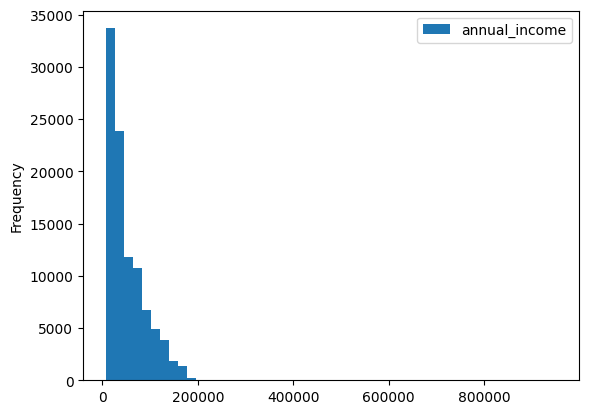

In [120]:
train_df_light[train_df_light["annual_income"] < 1000000].plot(kind="hist", y="annual_income", bins=50)

To me this looks like a much more sensible distribution below $200k. Since I don't want to just set an arbitrary number as the cutoff, I'll use the same outlier remover I defined previously.

<Axes: ylabel='Frequency'>

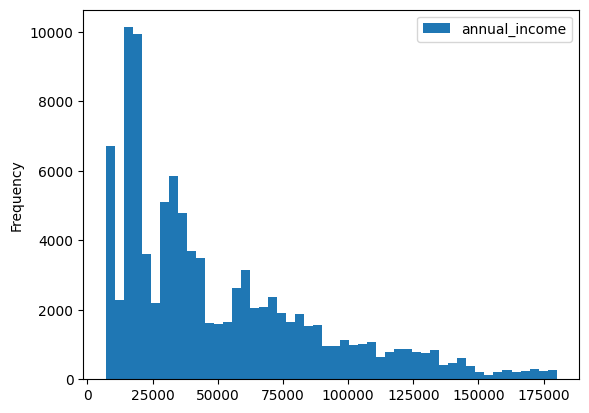

In [121]:
# Apply the outlier removal transformer to the annual_income column
train_df_cleaned["annual_income"] = outlier_remover.fit_transform(train_df_light[["annual_income"]])
train_df_cleaned.plot(kind="hist", y="annual_income", bins=50)

In [122]:
train_df_light["annual_income"].min()

np.float64(7005.93)

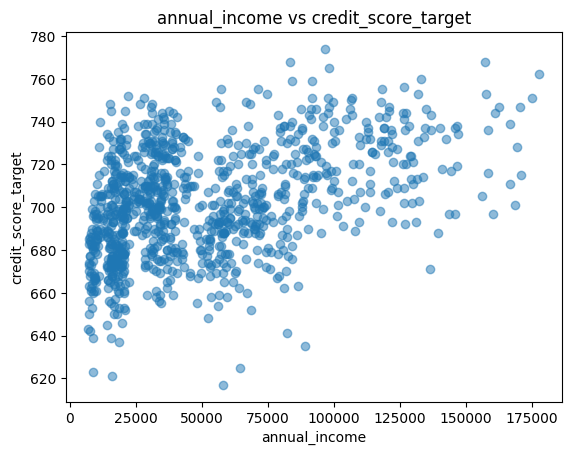

In [123]:
plot_numerical_feature_vs_target(train_df_cleaned, "annual_income", sample_size=1000)

We see a positive correlation between annual income and credit score, as expected.

### Monthly Inhand Salary

In [124]:
train_df_light["monthly_inhand_salary"].describe()

count    84998.000000
mean      4194.170850
std       3183.686167
min        303.645417
25%       1625.568229
50%       3093.745000
75%       5957.448333
max      15204.633333
Name: monthly_inhand_salary, dtype: float64

<Axes: ylabel='Frequency'>

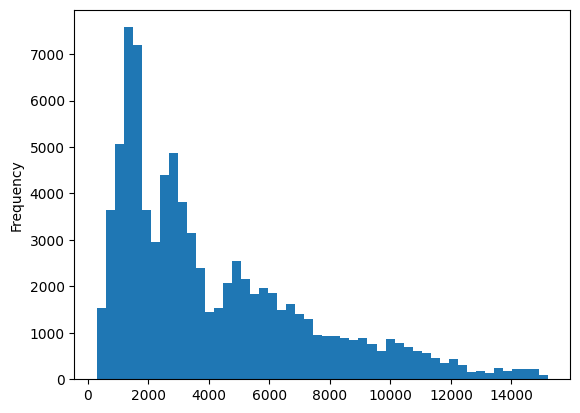

In [125]:
train_df_light["monthly_inhand_salary"].plot(kind="hist", bins=50)

This one looks fine to me, there's always a chance that in production this feature produces some outliers, so it's probably best to run it through my function from before.

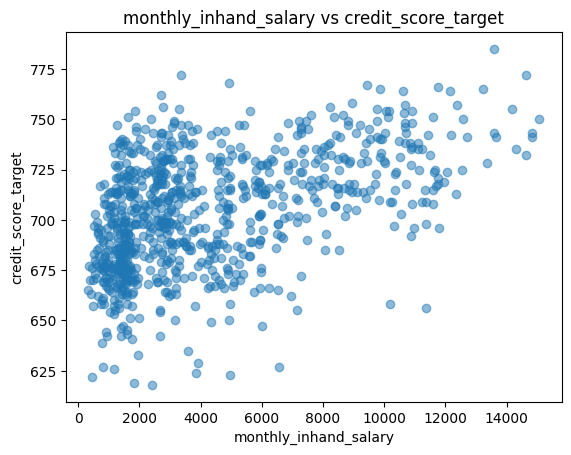

In [126]:
train_df_cleaned["monthly_inhand_salary"] = outlier_remover.fit_transform(train_df_light[["monthly_inhand_salary"]])
plot_numerical_feature_vs_target(train_df_cleaned, "monthly_inhand_salary", sample_size=1000)

## Number of bank accounts

In [127]:
train_df_light["num_bank_accounts"].describe()

count    100000.000000
mean         17.091280
std         117.404834
min          -1.000000
25%           3.000000
50%           6.000000
75%           7.000000
max        1798.000000
Name: num_bank_accounts, dtype: float64

Again, some really unusually large values for number of bank accounts, I'll apply the same outlier function as before. Also looks like like "-1" is supposed to be a null. Also, how can people have "0" bank accounts?

In [128]:
train_df_light[train_df_light["num_bank_accounts"] == 0].sample(10)

,age,occupation,annual_income,monthly_inhand_salary,num_bank_accounts,num_credit_card,interest_rate,num_of_loan,type_of_loan,delay_from_due_date,...,credit_utilization_ratio,credit_utilization_ratio_2,credit_utilization_ratio_3,credit_history_age,payment_of_min_amount,total_emi_per_month,amount_invested_monthly,payment_behaviour,monthly_balance,credit_score_target
52826,25,Doctor,28097.20,2397.433333,0,7,4,0.0,NaN,7,...,28.828927,28.828927,28.828927,29 Years and 5 Months,No,0.000000,219.517477,Low_spent_Small_value_payments,310.225856,740.0
71580,45,Architect,44620.44,3496.370000,0,5,12,2.0,"Not Specified, and Not Specified",4,...,29.305211,29.305211,29.305211,26 Years and 5 Months,No,50.788305,225.098878,High_spent_Small_value_payments,333.749817,727.0
80739,51,Lawyer,136738.56,11324.880000,0,6,11,0.0,NaN,14,...,28.472200,28.472200,28.472200,25 Years and 2 Months,NM,0.000000,690.913316,Low_spent_Small_value_payments,731.574684,705.0
28126,53,Teacher,37921.22,NaN,0,7,844,3.0,"Debt Consolidation Loan, Payday Loan, and Pers...",10,...,26.572272,26.572272,26.572272,30 Years and 10 Months,No,56.658479,68.979364,High_spent_Medium_value_payments,423.072324,712.0
2773,40,Journalist,42241.19,3231.099167,0,5,11,0.0,NaN,5,...,26.882053,26.882053,26.882053,25 Years and 8 Months,No,0.000000,334.943678,Low_spent_Medium_value_payments,268.166239,755.0
69068,43,Engineer,35251.49,2831.624167,0,4,2,-100.0,"Home Equity Loan, Payday Loan, and Credit-Buil...",8,...,29.968950,29.968950,29.968950,26 Years and 1 Months,No,78.047064,10000.000000,Low_spent_Small_value_payments,343.540906,696.0
3495,43,Architect,41499.21,3582.267500,0,5,5,0.0,NaN,4,...,34.085882,34.085882,34.085882,15 Years and 10 Months,No,0.000000,360.825366,Low_spent_Small_value_payments,287.401384,704.0
37311,24,Developer,32737.58,2729.131667,0,5,6,3.0,"Not Specified, Payday Loan, and Personal Loan",10,...,31.693911,31.693911,31.693911,30 Years and 9 Months,No,78.597023,107.692013,Low_spent_Medium_value_payments,366.624130,719.0
5696,21,Writer,136680.12,11420.010000,0,5,3,-100.0,Home Equity Loan,-1,...,34.292225,34.292225,34.292225,17 Years and 11 Months,No,112.995433,449.710635,Low_spent_Large_value_payments,849.294932,746.0
57276,26,Writer,61064.08,NaN,0,5,7,3.0,"Not Specified, Debt Consolidation Loan, and Cr...",0,...,29.162137,29.162137,29.162137,20 Years and 8 Months,No,94.256006,231.669591,High_spent_Small_value_payments,439.441736,718.0


While it feels strange that some users have no bank account, my intuition tells me that this is not MAR - there's probably a reason why some users go down as not having one. Likewise the "-1" is a special value and shouldn't be imputed. I'll apply my outlier remover though.

In [129]:
train_df_cleaned["num_bank_accounts"] = outlier_remover.fit_transform(train_df_light[["num_bank_accounts"]])
train_df_cleaned["num_bank_accounts"].describe()

count    98685.000000
mean         5.367624
std          2.593839
min         -1.000000
25%          3.000000
50%          5.000000
75%          7.000000
max         11.000000
Name: num_bank_accounts, dtype: float64

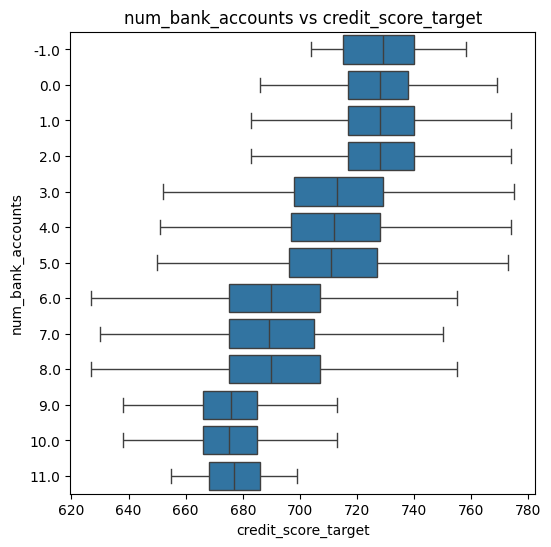

In [130]:
plot_categorical_feature_vs_target(train_df_cleaned, "num_bank_accounts")

As expected - "0" and "-1" probably carries some meaning.

### Number of credit cards

In [131]:
train_df_light["num_credit_card"].describe()

count    100000.00000
mean         22.47443
std         129.05741
min           0.00000
25%           4.00000
50%           5.00000
75%           7.00000
max        1499.00000
Name: num_credit_card, dtype: float64

Same again, apply outlier removal.

In [132]:
train_df_cleaned["num_credit_card"] = outlier_remover.fit_transform(train_df_light[["num_credit_card"]])
train_df_cleaned["num_credit_card"].describe()

count    97729.000000
mean         5.533322
std          2.067703
min          0.000000
25%          4.000000
50%          5.000000
75%          7.000000
max         11.000000
Name: num_credit_card, dtype: float64

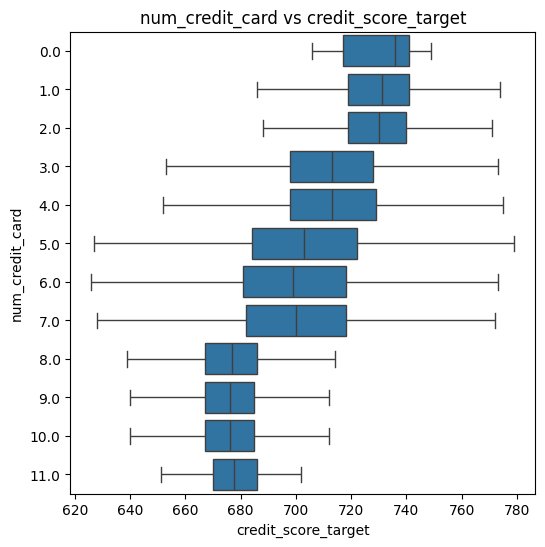

In [133]:
plot_categorical_feature_vs_target(train_df_cleaned, "num_credit_card")

### Interest rate

In [134]:
train_df_light["interest_rate"].describe()

count    100000.000000
mean         72.466040
std         466.422621
min           1.000000
25%           8.000000
50%          13.000000
75%          20.000000
max        5797.000000
Name: interest_rate, dtype: float64

A bit of a pattern here! It is useful though because I can keep applying the same function, this will make it easier when I build a pipeline later.

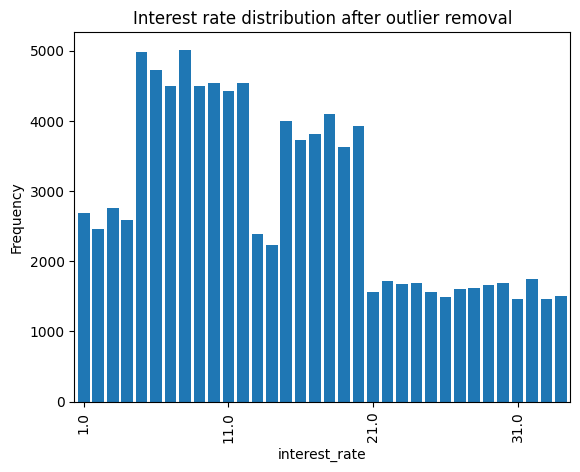

In [135]:
train_df_cleaned["interest_rate"] = outlier_remover.fit_transform(train_df_light[["interest_rate"]])
plot_discrete_distribution(train_df_cleaned["interest_rate"].dropna(), "Interest rate distribution after outlier removal")

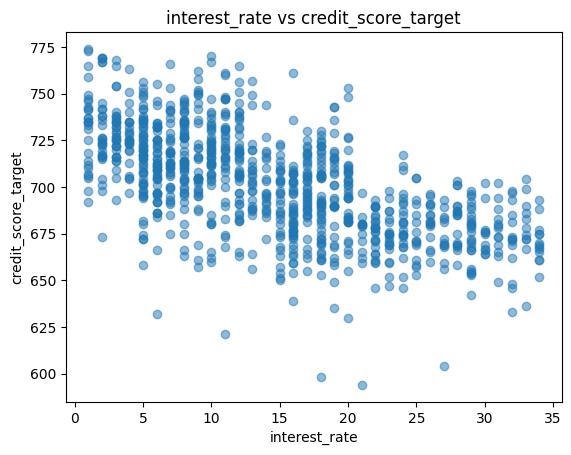

In [136]:
plot_numerical_feature_vs_target(train_df_cleaned, "interest_rate", sample_size=1000)

Interest rates are negatively correlated with credit score as expected.

### Number of loans

In [137]:
train_df_light["num_of_loan"].describe()

count    100000.000000
mean          3.009960
std          62.647879
min        -100.000000
25%           1.000000
50%           3.000000
75%           5.000000
max        1496.000000
Name: num_of_loan, dtype: float64

Same deal as before. Also -100 should be NaN. 

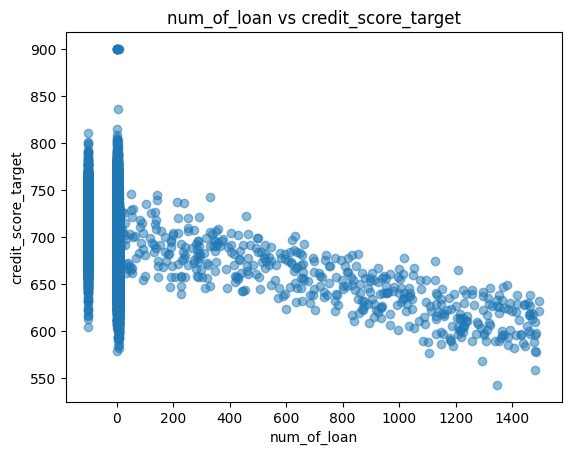

In [138]:
plot_numerical_feature_vs_target(train_df_light, "num_of_loan")

This is strange. I'm not sure I believe that people can 1400 loans, but it does look like there's a clear trend that number of loans negatively correlates with credit score. I'm going to leave this one be. I'll impute "-100" as null though.

In [139]:
minus_100_remover = SimpleImputer(missing_values=-100, strategy="constant", fill_value=None)
train_df_cleaned["num_of_loan"] = minus_100_remover.fit_transform(train_df_light[["num_of_loan"]])
train_df_cleaned["num_of_loan"].describe()

count    100000.000000
mean          6.885960
std          59.150621
min           0.000000
25%           1.000000
50%           3.000000
75%           5.000000
max        1496.000000
Name: num_of_loan, dtype: float64

### Type of Loan

In [140]:
train_df_light["type_of_loan"].value_counts(dropna=False).head(20)

type_of_loan
NaN                                         11408
Not Specified                                1408
Credit-Builder Loan                          1280
Personal Loan                                1272
Debt Consolidation Loan                      1264
Student Loan                                 1240
Payday Loan                                  1200
Mortgage Loan                                1176
Auto Loan                                    1152
Home Equity Loan                             1136
Personal Loan, and Student Loan               320
Not Specified, and Payday Loan                272
Mortgage Loan, and Home Equity Loan           264
Student Loan, and Payday Loan                 256
Student Loan, and Credit-Builder Loan         248
Credit-Builder Loan, and Not Specified        248
Payday Loan, and Debt Consolidation Loan      240
Payday Loan, and Auto Loan                    240
Mortgage Loan, and Not Specified              232
Payday Loan, and Personal Loan       

This is going to be a bit of a pain, there is a text string in plain English saying what kind of loan there is. I'm going to split them out into binary columns which mark if the customer has that type of loan. Luckily there are only 8 types of loan, the rest are just combinations of them.

In [141]:
TYPES_OF_LOAN = [
    "Not Specified",
    "Credit-Builder Loan",
    "Personal Loan",
    "Debt Consolidation Loan",
    "Student Loan",
    "Payday Loan",
    "Mortgage Loan",
    "Auto Loan",
    "Home Equity Loan"
]

In [142]:
train_df_light["type_of_loan"]

0        Auto Loan, Credit-Builder Loan, Personal Loan,...
1        Auto Loan, Credit-Builder Loan, Personal Loan,...
2        Auto Loan, Credit-Builder Loan, Personal Loan,...
3        Auto Loan, Credit-Builder Loan, Personal Loan,...
4        Auto Loan, Credit-Builder Loan, Personal Loan,...
                               ...                        
99995                          Auto Loan, and Student Loan
99996                          Auto Loan, and Student Loan
99997                          Auto Loan, and Student Loan
99998                          Auto Loan, and Student Loan
99999                          Auto Loan, and Student Loan
Name: type_of_loan, Length: 100000, dtype: object

In [143]:
class LoanTypeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, loan_types=None):
        if loan_types is None:
            loan_types = [
                "Not Specified",
                "Credit-Builder Loan",
                "Personal Loan",
                "Debt Consolidation Loan",
                "Student Loan",
                "Payday Loan",
                "Mortgage Loan",
                "Auto Loan",
                "Home Equity Loan"
            ]
        self.loan_types = loan_types

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X = X.fillna("")
        for loan_type in self.loan_types:
            X[loan_type] = X["type_of_loan"].apply(lambda x: x.count(loan_type))
        X = X.iloc[:, 1:]
        return X     

# Apply the transformer to the DataFrame
loan_type_transformer = LoanTypeTransformer()
train_df_cleaned[TYPES_OF_LOAN] = loan_type_transformer.fit_transform(train_df_light[["type_of_loan"]])

In [144]:
# Sum the binary loan columns for each row
loan_columns_sum = train_df_cleaned[TYPES_OF_LOAN].sum(axis=1)

# Compare the sum to the num_of_loan column
comparison = loan_columns_sum == train_df_light["num_of_loan"]

# Check if all comparisons are True
all_equal = comparison.all()

print(f"All sums equal to num_of_loan: {all_equal}")

All sums equal to num_of_loan: False


Something interesting here is that we could probably backfill the number of loans for those that are NaN. In fact, now that I think about it, the number of loans column is quite redundant. I'll drop it and instead create separate columns as counts for each type of loan.

This also gets around the issue with the high counts for number of loans.

In [145]:
train_df_cleaned = train_df_cleaned.drop(columns=["num_of_loan"])

### Delay from due date

<Axes: ylabel='Frequency'>

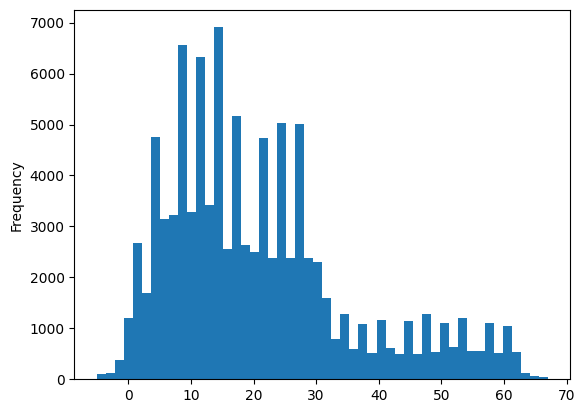

In [146]:
train_df_light["delay_from_due_date"].plot(kind="hist", bins=50)

In [147]:
train_df_light["delay_from_due_date"].value_counts(dropna=False).sort_index()

delay_from_due_date
-5      33
-4      62
-3     118
-2     168
-1     210
      ... 
 63     69
 64     64
 65     56
 66     32
 67     22
Name: count, Length: 73, dtype: int64

I'm going to make the assumption that minus values are okay for this feature - I'm interpreting it as they pay early (or might be classical special values from credit bureaus?). Everything else looks fine.

In [148]:
train_df_cleaned["delay_from_due_date"] = outlier_remover.fit_transform(train_df_light[["delay_from_due_date"]])

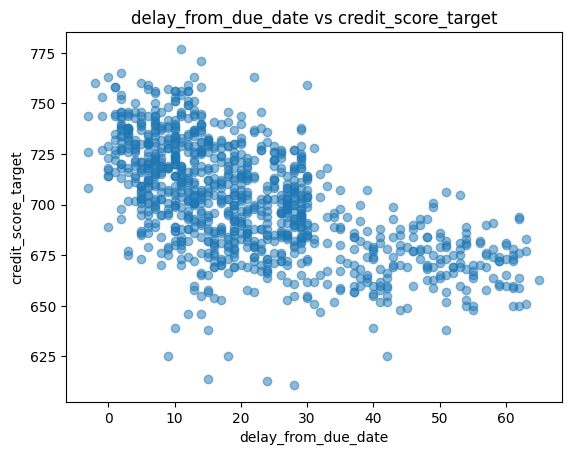

In [149]:
plot_numerical_feature_vs_target(train_df_cleaned, "delay_from_due_date", sample_size=1000)

A slight negative correlation as expected.

### num_of_delayed_payment

In [150]:
train_df_light["num_of_delayed_payment"].describe()

count    92998.000000
mean        30.923342
std        226.031892
min         -3.000000
25%          9.000000
50%         14.000000
75%         18.000000
max       4397.000000
Name: num_of_delayed_payment, dtype: float64

I'll apply my outlier function here. I'm going to interpret the minuses as special values - common in credit risk, often it's better not to impute them because they actually carry some meaning.

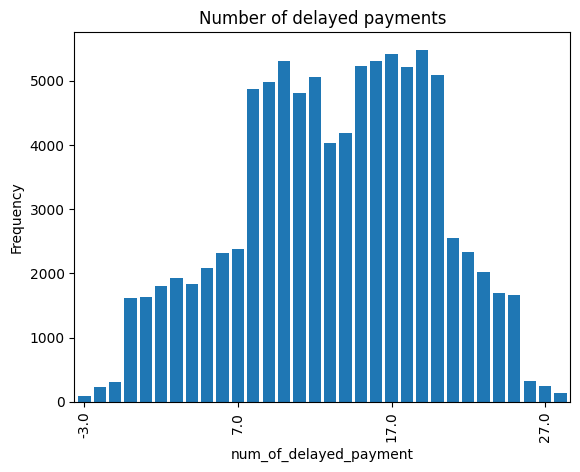

In [151]:
train_df_cleaned["num_of_delayed_payment"] = outlier_remover.fit_transform(train_df_light[["num_of_delayed_payment"]])
plot_discrete_distribution(train_df_cleaned["num_of_delayed_payment"].dropna(), "Number of delayed payments")

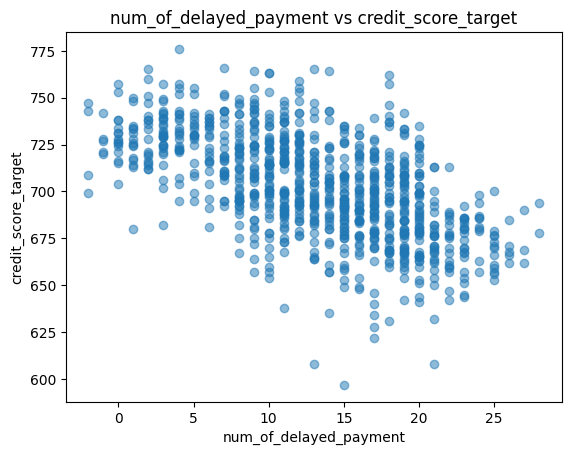

In [152]:
plot_numerical_feature_vs_target(train_df_cleaned, "num_of_delayed_payment", sample_size=1000)

### changed_credit_limit

In [153]:
train_df_light["changed_credit_limit"].describe()

count    97909.000000
mean        10.389025
std          6.789496
min         -6.490000
25%          5.320000
50%          9.400000
75%         14.870000
max         36.970000
Name: changed_credit_limit, dtype: float64

<Axes: ylabel='Frequency'>

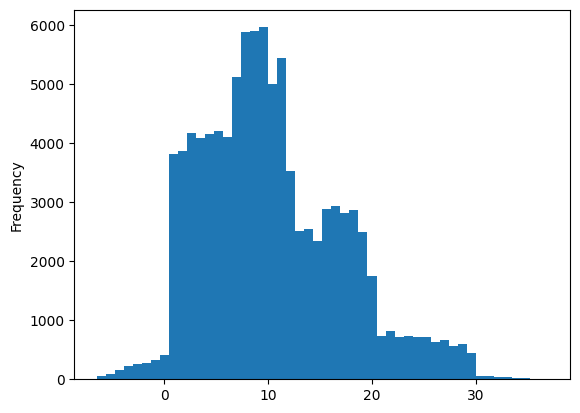

In [154]:
train_df_light["changed_credit_limit"].plot(kind="hist", bins=50)

Looks fine.

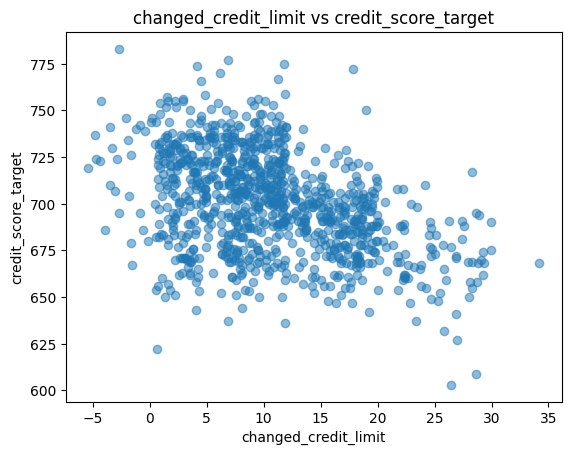

In [155]:
train_df_cleaned["changed_credit_limit"] = outlier_remover.fit_transform(train_df_light[["changed_credit_limit"]])
plot_numerical_feature_vs_target(train_df_cleaned, "changed_credit_limit", sample_size=1000)

Slight negative correlation which makes sense.

### num_credit_inquiries

In [156]:
train_df_light["num_credit_inquiries"].describe()

count    98035.000000
mean        37.683897
std        264.829955
min          0.000000
25%          3.400000
50%          7.200000
75%         11.900000
max       4341.800000
Name: num_credit_inquiries, dtype: float64

<Axes: ylabel='Frequency'>

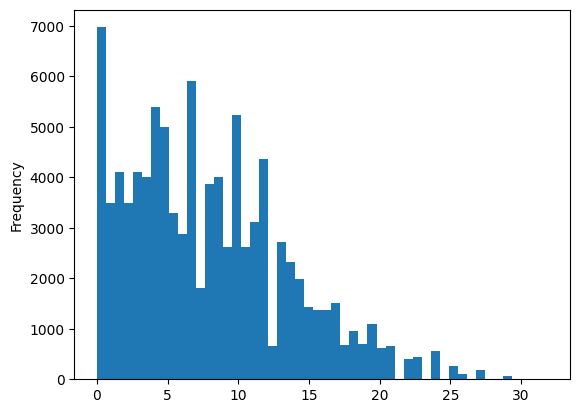

In [157]:
train_df_cleaned["num_credit_inquiries"] = outlier_remover.fit_transform(train_df_light[["num_credit_inquiries"]])
train_df_cleaned["num_credit_inquiries"].plot(kind="hist", bins=50)

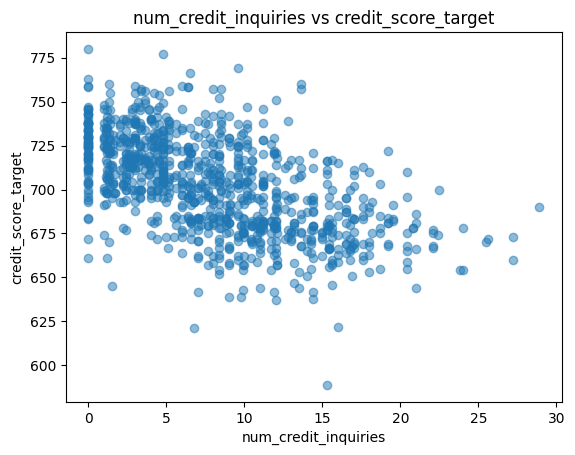

In [158]:
plot_numerical_feature_vs_target(train_df_cleaned, "num_credit_inquiries", sample_size=1000)

Slight negative correlation as expected.

### outstanding_debt

In [159]:
train_df_light["outstanding_debt"].describe()

count    100000.000000
mean       1426.220376
std        1155.129026
min           0.230000
25%         566.072500
50%        1166.155000
75%        1945.962500
max        4998.070000
Name: outstanding_debt, dtype: float64

Looks fine to me - a bit strange that it looks like a step function but that's ok. 

<Axes: ylabel='Frequency'>

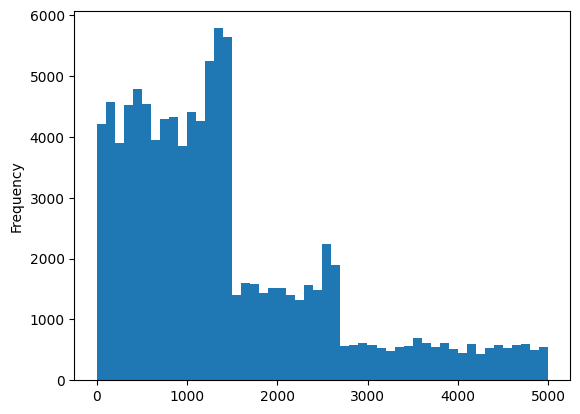

In [160]:
train_df_cleaned["outstanding_debt"] = outlier_remover.fit_transform(train_df_light[["outstanding_debt"]])
train_df_cleaned["outstanding_debt"].plot(kind="hist", bins=50)

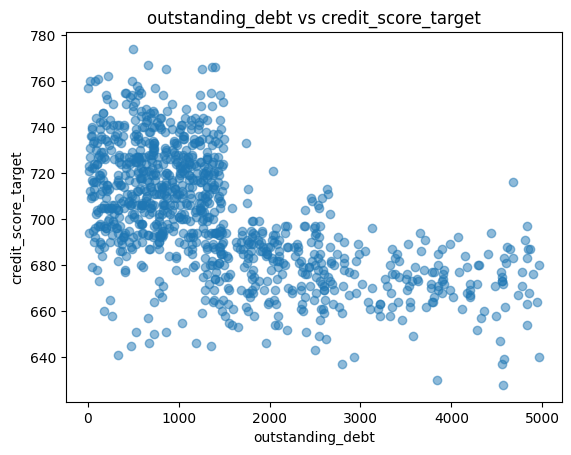

In [161]:
plot_numerical_feature_vs_target(train_df_cleaned, "outstanding_debt", sample_size=1000)

Slight negative correlation - again what I would expect.

### credit_utilization_ratio

In [162]:
train_df_light["credit_utilization_ratio"].describe()

count    100000.000000
mean         32.285173
std           5.116875
min          20.000000
25%          28.052567
50%          32.305784
75%          36.496663
max          50.000000
Name: credit_utilization_ratio, dtype: float64

<Axes: ylabel='Frequency'>

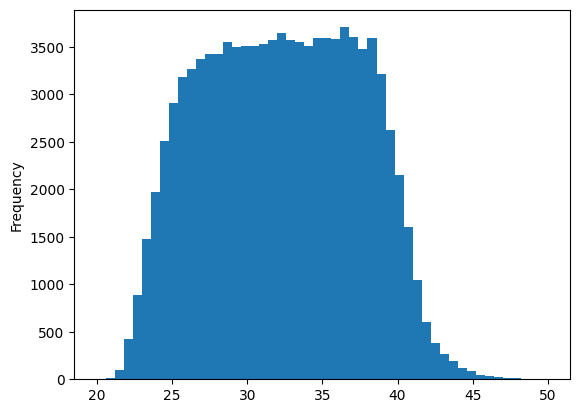

In [163]:
train_df_light["credit_utilization_ratio"].plot(kind="hist", bins=50)

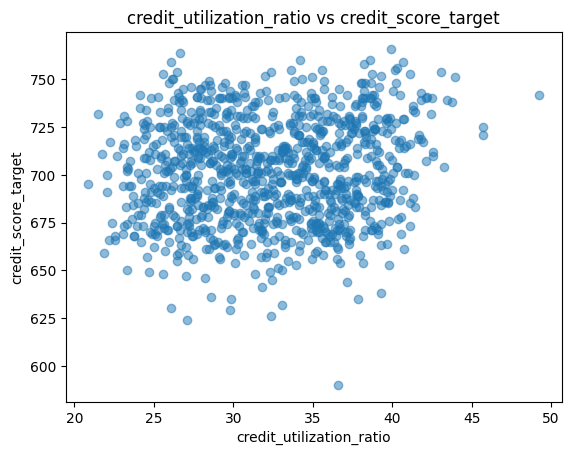

In [164]:
train_df_cleaned["credit_utilization_ratio"] = outlier_remover.fit_transform(train_df_light[["credit_utilization_ratio"]])
plot_numerical_feature_vs_target(train_df_cleaned, "credit_utilization_ratio", sample_size=1000)

I'm not seeing much correlation here but perhaps there are some unseen non-linear relationships that a model will pick up.

### credit_utilization_ratio_2

<Axes: ylabel='Frequency'>

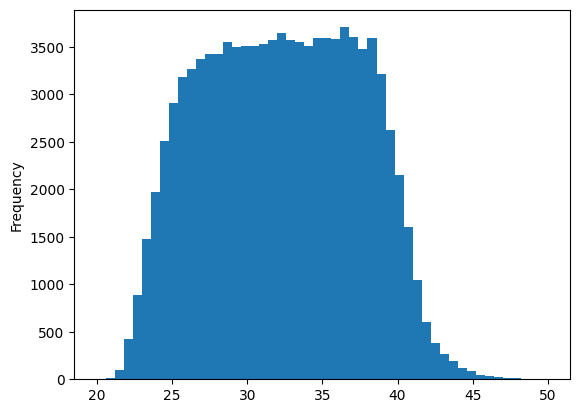

In [165]:
train_df_light["credit_utilization_ratio_2"].plot(kind="hist", bins=50)

Are they the same?

In [166]:
train_df_light[["credit_utilization_ratio", "credit_utilization_ratio_2", "credit_utilization_ratio_3"]]

,credit_utilization_ratio,credit_utilization_ratio_2,credit_utilization_ratio_3
0,26.822620,26.822620,26.822620
1,31.944960,31.944960,31.944960
2,28.609352,28.609352,28.609352
3,31.377862,31.377862,31.377862
4,24.797347,24.797347,24.797347
...,...,...,...
99995,34.663572,34.663572,34.663572
99996,40.565631,40.565631,40.565631
99997,41.255522,41.255522,41.255522
99998,33.638208,33.638208,33.638208


In [167]:
credit_util_comparison = (train_df_light["credit_utilization_ratio"] == train_df_light["credit_utilization_ratio_2"]) & \
                         (train_df_light["credit_utilization_ratio_2"] == train_df_light["credit_utilization_ratio_3"])

all_credit_util_equal = credit_util_comparison.all()

print(f"All credit utilization ratios are the same: {all_credit_util_equal}")

All credit utilization ratios are the same: True


They're the same, no need for 2 and 3.

### credit_history_age

In [168]:
train_df_light["credit_history_age"].value_counts(dropna=False).sort_index()

credit_history_age
0 Years and 1 Months        2
0 Years and 10 Months      79
0 Years and 11 Months      77
0 Years and 2 Months       15
0 Years and 3 Months       20
                         ... 
9 Years and 6 Months      212
9 Years and 7 Months      219
9 Years and 8 Months      251
9 Years and 9 Months      261
NaN                      9030
Name: count, Length: 405, dtype: int64

This would be better suited as a numerical column.

In [169]:
class CreditHistoryAgeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X = X.apply(self.parse_credit_history_age)
        return X

    @staticmethod
    def parse_credit_history_age(age_string: str) -> int:
        """Parses a string to extract an integer credit history age value.
        
        Args:
            age_string (str): The string containing the credit history age value.
            
        Returns:
            int: The parsed integer credit history age value.
        """
        try:
            years = int(age_string.split(" ")[0])
        except (AttributeError, ValueError, IndexError):
            return None
        
        try:
            months = int(age_string.split(" ")[3])
        except (AttributeError, ValueError, IndexError):
            return 0
            
        return years * 12 + months

# Apply the transformer to the DataFrame
credit_history_age_transformer = CreditHistoryAgeTransformer()
train_df_cleaned["credit_history_age"] = credit_history_age_transformer.fit_transform(train_df_light["credit_history_age"])

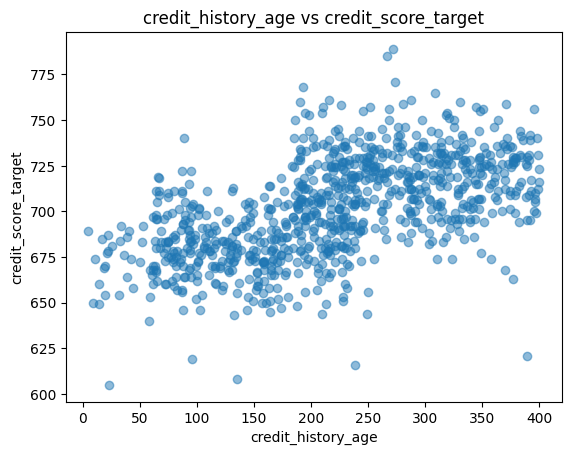

In [170]:
plot_numerical_feature_vs_target(train_df_cleaned, "credit_history_age", sample_size=1000)

Makes sense to me.

### payment_of_min_amount

In [171]:
train_df_light["payment_of_min_amount"].value_counts(dropna=False).sort_index()

payment_of_min_amount
NM     12007
No     35667
Yes    52326
Name: count, dtype: int64

Nothing to do here, I'm assuming NM is just a null value.

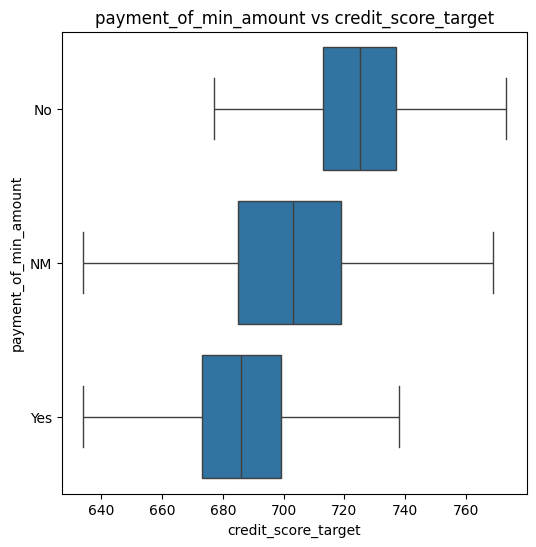

In [172]:
train_df_cleaned["payment_of_min_amount"] = train_df_light["payment_of_min_amount"]
plot_categorical_feature_vs_target(train_df_cleaned, "payment_of_min_amount")

Makes sense again.

### total_emi_per_month

In [173]:
train_df_light["total_emi_per_month"].describe()

count    100000.000000
mean       1403.118217
std        8306.041270
min           0.000000
25%          30.306660
50%          69.249473
75%         161.224249
max       82331.000000
Name: total_emi_per_month, dtype: float64

<Axes: ylabel='Frequency'>

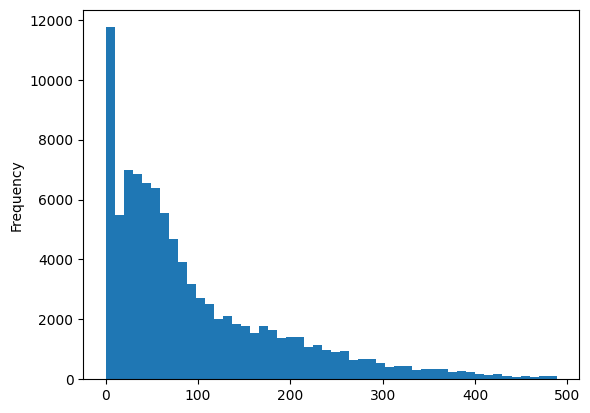

In [174]:
train_df_cleaned["total_emi_per_month"] = outlier_remover.fit_transform(train_df_light[["total_emi_per_month"]])
train_df_cleaned["total_emi_per_month"].plot(kind="hist", bins=50)

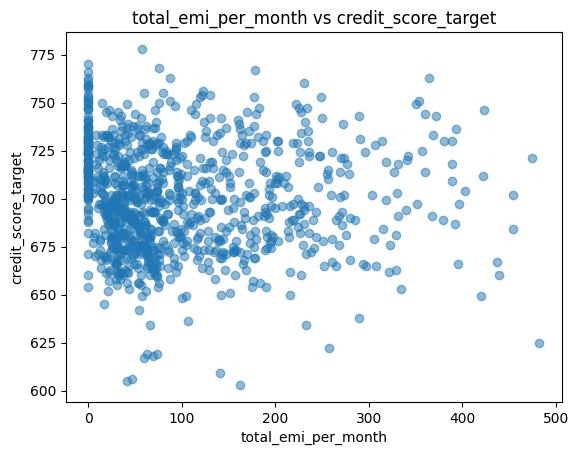

In [175]:
plot_numerical_feature_vs_target(train_df_cleaned, "total_emi_per_month", sample_size=1000)

### amount_invested_monthly

In [176]:
train_df_light["amount_invested_monthly"].describe()

count    95521.000000
mean       637.412998
std       2043.319327
min          0.000000
25%         74.534002
50%        135.925682
75%        265.731733
max      10000.000000
Name: amount_invested_monthly, dtype: float64

In [177]:
train_df_light[train_df_light["amount_invested_monthly"] > 8000].sample(5)

,age,occupation,annual_income,monthly_inhand_salary,num_bank_accounts,num_credit_card,interest_rate,num_of_loan,type_of_loan,delay_from_due_date,...,credit_utilization_ratio,credit_utilization_ratio_2,credit_utilization_ratio_3,credit_history_age,payment_of_min_amount,total_emi_per_month,amount_invested_monthly,payment_behaviour,monthly_balance,credit_score_target
59529,20,Engineer,115736.92,9541.743333,8,3,8,3.0,"Mortgage Loan, Not Specified, and Debt Consoli...",11,...,29.747762,29.747762,29.747762,24 Years and 4 Months,Yes,255.747565,10000.0,High_spent_Medium_value_payments,631.587003,698.0
69664,23,_______,64269.24,5112.770000,6,7,6,6.0,"Payday Loan, Debt Consolidation Loan, Credit-B...",21,...,37.212191,37.212191,37.212191,13 Years and 9 Months,NM,268.313996,10000.0,High_spent_Medium_value_payments,336.800430,682.0
75178,21,Writer,17515.75,1691.645833,7,9,27,6.0,"Personal Loan, Student Loan, Debt Consolidatio...",57,...,39.422770,39.422770,39.422770,7 Years and 6 Months,Yes,79.935796,10000.0,Low_spent_Medium_value_payments,284.739445,630.0
45647,49,Architect,36377.09,3146.424167,1,5,3,4.0,"Home Equity Loan, Debt Consolidation Loan, Pay...",11,...,33.410862,33.410862,33.410862,16 Years and 2 Months,No,117.279484,10000.0,!@9#%8,279.005499,683.0
79049,18,Manager,18587.64,1578.970000,6,8,17,7.0,"Student Loan, Credit-Builder Loan, Student Loa...",36,...,24.933154,24.933154,24.933154,7 Years and 10 Months,Yes,61.099331,10000.0,Low_spent_Small_value_payments,328.509234,636.0


The spike at 10k doesn't seem right to be me, there are people putting aside £10k each month on £26k salaries. I'll apply my function agaain.

<Axes: ylabel='Frequency'>

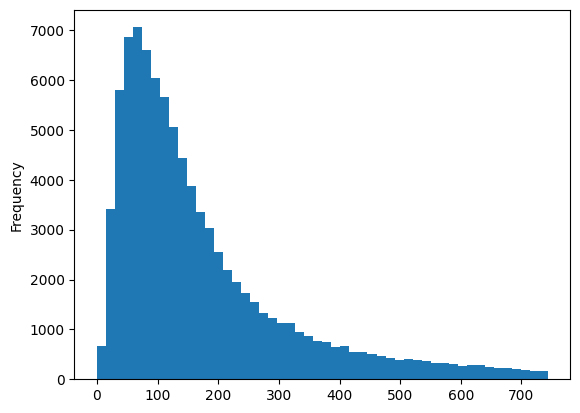

In [178]:
train_df_cleaned["amount_invested_monthly"] = outlier_remover.fit_transform(train_df_light[["amount_invested_monthly"]])
train_df_cleaned["amount_invested_monthly"].plot(kind="hist", bins=50)

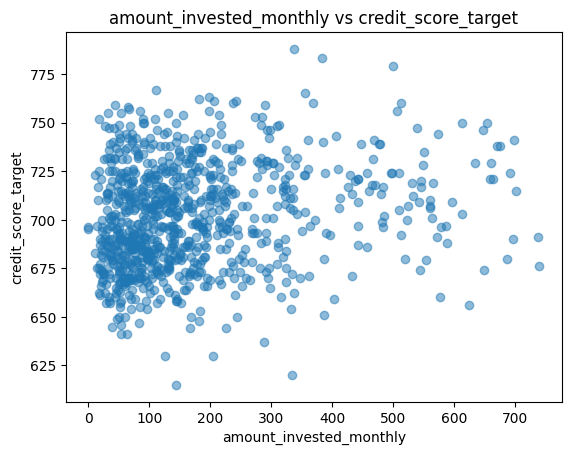

In [179]:
plot_numerical_feature_vs_target(train_df_cleaned, "amount_invested_monthly", sample_size=1000)

### payment_behaviour

In [180]:
train_df_light["payment_behaviour"].value_counts(dropna=False).sort_index()

payment_behaviour
!@9#%8                               7600
High_spent_Large_value_payments     13721
High_spent_Medium_value_payments    17540
High_spent_Small_value_payments     11340
Low_spent_Large_value_payments      10425
Low_spent_Medium_value_payments     13861
Low_spent_Small_value_payments      25513
Name: count, dtype: int64

In [181]:
# Remove that weird value
garbage_remover = SimpleImputer(missing_values="!@9#%8", strategy="constant", fill_value=None)
train_df_cleaned["payment_behaviour"] = garbage_remover.fit_transform(train_df_light[["payment_behaviour"]]).flatten()

In [182]:
train_df_cleaned["payment_behaviour"].value_counts(dropna=False).sort_index()

payment_behaviour
High_spent_Large_value_payments     13721
High_spent_Medium_value_payments    17540
High_spent_Small_value_payments     11340
Low_spent_Large_value_payments      10425
Low_spent_Medium_value_payments     13861
Low_spent_Small_value_payments      25513
missing_value                        7600
Name: count, dtype: int64

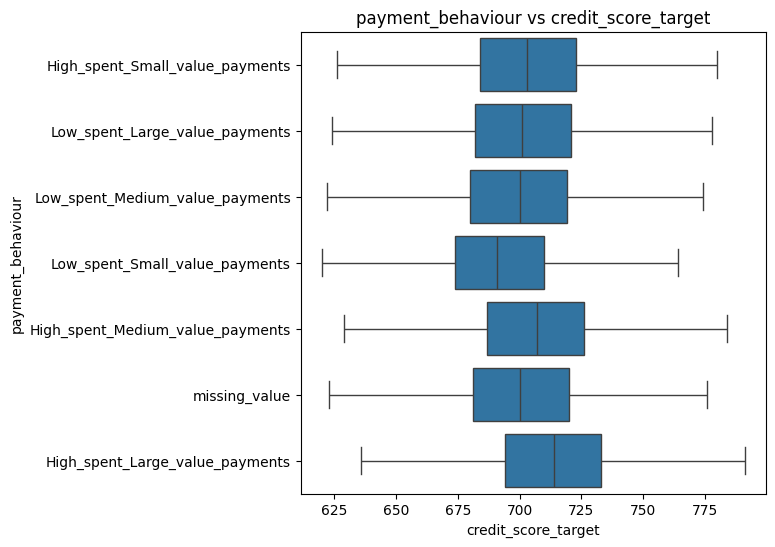

In [183]:
plot_categorical_feature_vs_target(train_df_cleaned, "payment_behaviour")

### monthly_balance

In [184]:
train_df_light["monthly_balance"].describe()

count    9.880000e+04
mean    -3.036437e+22
std      3.181295e+24
min     -3.333333e+26
25%      2.700922e+02
50%      3.367192e+02
75%      4.702202e+02
max      1.602041e+03
Name: monthly_balance, dtype: float64

<Axes: ylabel='Frequency'>

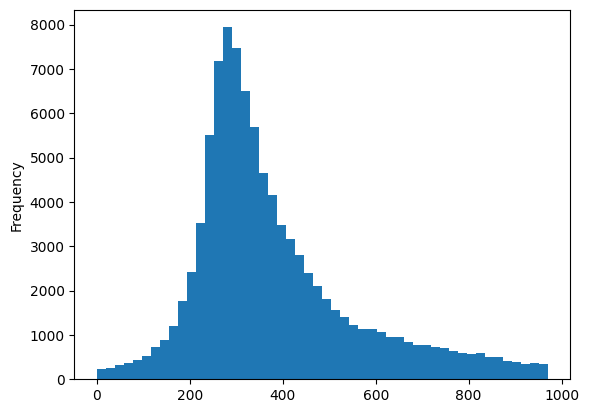

In [185]:
train_df_cleaned["monthly_balance"] = outlier_remover.fit_transform(train_df_light[["monthly_balance"]])
train_df_cleaned["monthly_balance"].plot(kind="hist", bins=50)

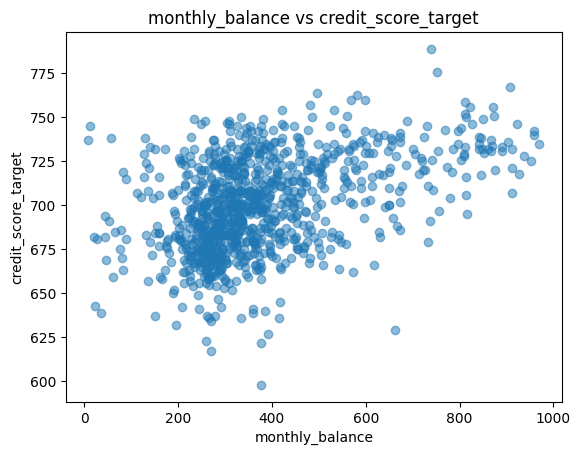

In [186]:
plot_numerical_feature_vs_target(train_df_cleaned, "monthly_balance", sample_size=1000)

### credit_score_target

<Axes: ylabel='Frequency'>

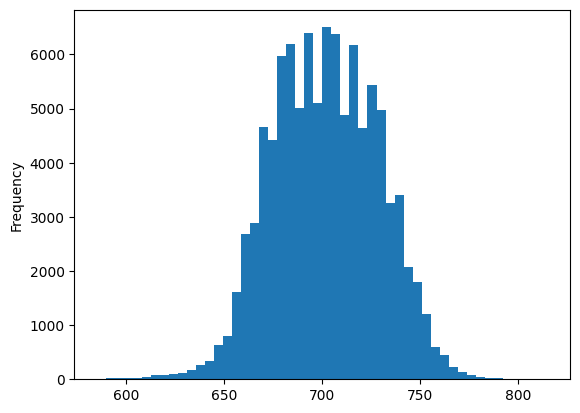

In [187]:
train_df_cleaned["credit_score_target"].plot(kind="hist", bins=50)

In [188]:
train_df_cleaned["credit_score_target"].isna().sum()

np.int64(22)

In [189]:
train_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   credit_score_target       99978 non-null   float64
 1   age                       97219 non-null   float64
 2   occupation                100000 non-null  object 
 3   annual_income             99001 non-null   float64
 4   monthly_inhand_salary     84998 non-null   float64
 5   num_bank_accounts         98685 non-null   float64
 6   num_credit_card           97729 non-null   float64
 7   interest_rate             97966 non-null   float64
 8   Not Specified             100000 non-null  int64  
 9   Credit-Builder Loan       100000 non-null  int64  
 10  Personal Loan             100000 non-null  int64  
 11  Debt Consolidation Loan   100000 non-null  int64  
 12  Student Loan              100000 non-null  int64  
 13  Payday Loan               100000 non-null  in

In [190]:
train_df_cleaned.head()

,credit_score_target,age,occupation,annual_income,monthly_inhand_salary,num_bank_accounts,num_credit_card,interest_rate,Not Specified,Credit-Builder Loan,...,changed_credit_limit,num_credit_inquiries,outstanding_debt,credit_utilization_ratio,credit_history_age,payment_of_min_amount,total_emi_per_month,amount_invested_monthly,payment_behaviour,monthly_balance
0,721.0,23.0,Scientist,19114.12,1824.843333,3.0,4.0,3.0,0,1,...,11.27,4.0,809.98,26.822620,265.0,No,49.574949,80.415295,High_spent_Small_value_payments,312.494089
1,726.0,23.0,Scientist,19114.12,NaN,3.0,4.0,3.0,0,1,...,11.27,4.4,809.98,31.944960,NaN,No,49.574949,118.280222,Low_spent_Large_value_payments,284.629162
2,716.0,NaN,Scientist,19114.12,NaN,3.0,4.0,3.0,0,1,...,NaN,4.8,809.98,28.609352,267.0,No,49.574949,81.699521,Low_spent_Medium_value_payments,331.209863
3,710.0,23.0,Scientist,19114.12,NaN,3.0,4.0,3.0,0,1,...,6.27,5.2,809.98,31.377862,268.0,No,49.574949,199.458074,Low_spent_Small_value_payments,223.451310
4,738.0,23.0,Scientist,19114.12,1824.843333,3.0,4.0,3.0,0,1,...,11.27,5.6,809.98,24.797347,269.0,No,49.574949,41.420153,High_spent_Medium_value_payments,341.489231


In [191]:
train_df_cleaned["age"].describe()

count    97219.000000
mean        33.320009
std         10.769558
min         14.000000
25%         24.000000
50%         33.000000
75%         42.000000
max         56.000000
Name: age, dtype: float64

Next, I'll define all of the above in a custom transformer class (in `zilch_interview/prepare.py`) so I can use it consistently across the project.

In [192]:
from zilch_interview.prepare import DataCleaner

data_cleaner = DataCleaner()
train_df_transformed = data_cleaner.fit_transform(train_df)

                                            type_of_loan
0      Auto Loan, Credit-Builder Loan, Personal Loan,...
1      Auto Loan, Credit-Builder Loan, Personal Loan,...
2      Auto Loan, Credit-Builder Loan, Personal Loan,...
3      Auto Loan, Credit-Builder Loan, Personal Loan,...
4      Auto Loan, Credit-Builder Loan, Personal Loan,...
...                                                  ...
99995                        Auto Loan, and Student Loan
99996                        Auto Loan, and Student Loan
99997                        Auto Loan, and Student Loan
99998                        Auto Loan, and Student Loan
99999                        Auto Loan, and Student Loan

[100000 rows x 1 columns]


In [193]:
# Check that the two transformed DataFrames are equal
train_df_transformed.equals(train_df_cleaned[train_df_transformed.columns])

True

I'm happy that that custom cleaner is working as expected.